In [90]:
%matplotlib inline
import qiskit.tools.jupyter

from qiskit import *
from qiskit.visualization import plot_circuit_layout, plot_gate_map


IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl')

In [83]:
backend = provider.get_backend('ibmq_poughkeepsie')

<IBMQBackend('ibmq_poughkeepsie') from IBMQ(hub='ibm-q-afrl', group='air-force-lab', project='educational')>

In [62]:
# Import the quantum volume sub-module from Ignis
import qiskit.ignis.verification.quantum_volume as qv
import matplotlib.pyplot as plt
import numpy as np

# Also import Aer's noise model functionality to allow us to compare actual performance
# to that expected from device 1Q and 2Q error rates
from qiskit.providers.aer.noise.device.models import basic_device_noise_model
from qiskit.transpiler.coupling import CouplingMap


In [63]:
def find_subgraph(size: int, backend: backend) -> list:
    """Returns a list of integers corresponding to physical qubits forming a connected subgraph
    
    Args:
        size: integer defining the number of nodes that should be in the connected subgraph
        backend: real device backend to form the subgraph on
        
    Returns:
        subgraph: list of integers, each element corresponds to one physical qubit on backend.  
                  list size should be size.
    """
    
    import numpy as np
    
    
    perm = np.random.permutation(list(range(backend.configuration().n_qubits)))
    
    # Setup main graph to traverse
    c_list = backend.configuration().coupling_map
    c_map = CouplingMap(c_list)
    
    while not c_map.subgraph(perm[:size]).is_connected():
        perm = np.random.permutation(list(range(backend.configuration().n_qubits)))
    
    return perm[:size]
    
    
    

In [64]:
find_subgraph(5, backend)

array([14, 13, 12,  9,  7])

In [65]:
# from timeit import default_timer as timer

# start = timer()
# for _ in range(1000):
#     find_subgraph(7, backend)
# end = timer()
# print((end - start)/1000) # Time in seconds, e.g. 5.38091952400282

In [66]:
def cleanup_matrix(mx: list, norm: float) -> np.ndarray:
    new_mx = [[int(x.real / norm) for x in row] for row in matrix]
    
    return np.array(new_mx)

[[ 1  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  1]]


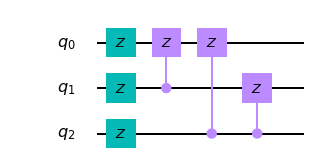

In [93]:
from qiskit import *
%matplotlib inline
q = QuantumRegister(3, 'q')
qc = QuantumCircuit(q)
qc.z(q)
qc.cz(q[1],q[0])
qc.cz(q[2],q[0])
qc.cz(q[2],q[1])


unitary_sim = Aer.get_backend('unitary_simulator')
matrix = execute(qc, unitary_sim).result().get_unitary()
print(cleanup_matrix(matrix, 1))

qc.draw(output='mpl')

In [ ]:
qv_test = transpile(qc, backend, initial_layout=find_subgraph(7, backend))
plot_circuit_layout(qv_test, backend)